In [75]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
from climate_index_collection.data_loading import (
    find_data_files,
    load_data_set,
    VARNAME_MAPPING
)
from climate_index_collection.reductions import (
    area_mean_weighted,
    monthly_anomalies_unweighted,
    stddev_unweighted,
)
from climate_index_collection.indices import (
    north_atlantic_oscillation_pc,
    north_atlantic_oscillation,
    southern_annular_mode,
)
from climate_index_collection.data_loading import load_and_preprocess_single_data_file

In [94]:
noaa_data = pd.read_csv('1880-2022.csv', header = 4)
noaa_data['time'] = pd.to_datetime(noaa_data['Year'], format='%Y%m',)
noaa_data = noaa_data.set_index('time')
noaa_data = noaa_data.drop("Year", axis=1)
display(noaa_data.std())

Value    0.44711
dtype: float64

As one can see above, the data from NOAA is not standardized.

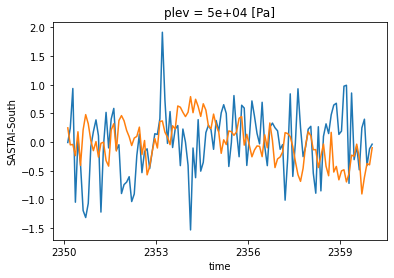

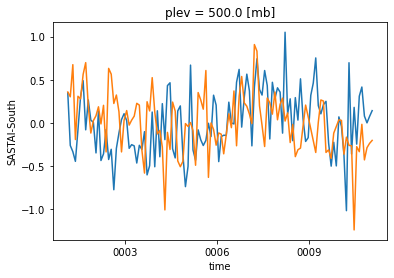

In [96]:
def sea_air_surface_temperature_anomaly_north(data_set, sat_name="sea-air-temperature"):
    """Sea Air Surface Temperature Anomaly (SASTA) index ,
    for the northern hemisphere.
    
    This follows https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies/anomalies
    Land and Sea temperature data is used.
    The Anomalies are climatoligical anomalies (monthly) relative to the whole time period of the data_set.
    
    Computation is done as follows:
    1. Compute area averaged total SAT for the hemisphere.
    2. Compute monthly climatology for area averaged SAT for the hemisphere.
    3. Subtract climatology from area averaged total SST time series to obtain anomalies.

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing a SAT field.
    slp_name: str
        Name of the Sea-Air Temperature field. Defaults to "sea-air-temperature".

    Returns
    -------
    xarray.DataArray
        Time series containing the SASTA index for northern hemisphere.

    """
    sea_air_temperature = area_mean_weighted(
        dobj=data_set[sat_name],
        lat_south=0,
        lat_north=90,
        lon_west=0,
        lon_east=360)
    
    sea_air_temp_anom = monthly_anomalies_unweighted(sea_air_temperature)
    SASTAI_North = sea_air_temp_anom.rename("SASTAI-North")

    return SASTAI_North
def sea_air_surface_temperature_anomaly_south(data_set, sat_name="sea-air-temperature"):
    """Sea Air Surface Temperature Anomaly (SASTA) index ,
    for the southern hemisphere.
    
    This follows https://www.ncei.noaa.gov/access/monitoring/global-temperature-anomalies/anomalies
    Land and Sea temperature data is used.
    The Anomalies are climatoligical anomalies (monthly) relative to the whole time period of the data_set.
    
    Computation is done as follows:
    1. Compute area averaged total SAT for the hemisphere.
    2. Compute monthly climatology for area averaged SAT for the hemisphere.
    3. Subtract climatology from area averaged total SST time series to obtain anomalies.

    Parameters
    ----------
    data_set: xarray.DataSet
        Dataset containing a SAT field.
    slp_name: str
        Name of the Sea-Air Temperature field. Defaults to "sea-air-temperature".

    Returns
    -------
    xarray.DataArray
        Time series containing the SASTA index for northern hemisphere.

    """
    sea_air_temperature = area_mean_weighted(
        dobj=data_set[sat_name],
        lat_south=-90,
        lat_north=0,
        lon_west=0,
        lon_east=360)
    
    sea_air_temp_anom = monthly_anomalies_unweighted(sea_air_temperature)
    SASTAI_South = sea_air_temp_anom.rename("SASTAI-South")

    return SASTAI_South

sea_air_surface_temperature_anomaly_north(FOCI_alldata).plot()
sea_air_surface_temperature_anomaly_south(FOCI_alldata).plot()
plt.figure()
sea_air_surface_temperature_anomaly_north(CESM_alldata).plot()
sea_air_surface_temperature_anomaly_south(CESM_alldata).plot()

In [69]:
FOCI_alldata = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
CESM_alldata = load_data_set(data_path="../data/test_data/", data_source_name="CESM")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [15]:
def 

<xarray.DataArray 'sea-surface-temperature' (lat: 96, lon: 192)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time     object 2350-12-16 12:00:00
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    plev     float64 5e+04

In [42]:
def get_land_mask(data) :
    mask = data['sea-surface-temperature']
    return mask


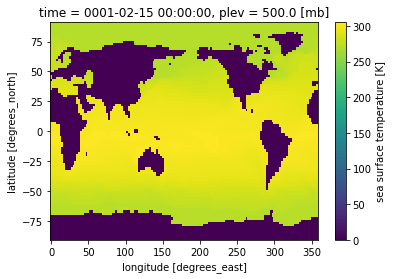

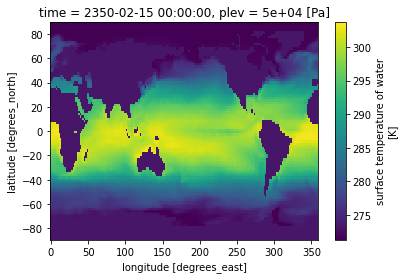

In [47]:
get_land_mask(CESM_alldata).isel(time = 0).plot()
plt.figure()
get_land_mask(FOCI_alldata).isel(time = 0).plot()